In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

import collections
import datetime
from IPython.display import clear_output, display, HTML
import itertools
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import os
from pathlib import Path
import pickle
import PIL
import scipy
import sklearn
from sklearn.decomposition import PCA
import sys

import pytoolsAL as ptAL
from neuropixels import * 
# import dualprobe as dupr
# import multipredictor as mpred

pytoolsAL: Modules missing.  Not loading image.  Message: cannot import name 'geometry' from 'skimage._shared' (c:\Users\nadia\anaconda3\envs\steinmetzlab\Lib\site-packages\skimage\_shared\__init__.py)
It seems that scikit-image has not been built correctly.

Your install of scikit-image appears to be broken.
Try re-installing the package following the instructions at:
https://scikit-image.org/docs/stable/user_guide/install.html
pytoolsAL: Modules missing.  Not loading plotting.  Message: No module named 'seaborn'


c:\Users\nadia\Documents\GitHub\steinmetzlab\wf + opto\figure-making\neuropixels.py:22: SyntaxWarning: invalid escape sequence '\S'
  """
c:\Users\nadia\Documents\GitHub\steinmetzlab\wf + opto\figure-making\neuropixels.py:454: SyntaxWarning: invalid escape sequence '\m'
  plt.ylabel('depth ($\mu$m)')
c:\Users\nadia\Documents\GitHub\steinmetzlab\wf + opto\figure-making\neuropixels.py:471: SyntaxWarning: invalid escape sequence '\m'
  plt.ylabel('depth ($\mu$m)')


In [2]:
import slidingRP

In [3]:
#work
plt.style.use(r'C:\Users\nadia\Documents\GitHub\steinmetzlab\ALpres.mplstyle')

#### experiment key
- 2: data folder
- 3: seven powers, three spots
- 4: RF mapping
- 5: bilateral inhib: three powers, two spots (left/right V1)
- 6 and 7 are errors
- 8: different durations, one power, sine wave vs step inhib

In [4]:
expdir = Path(r'Y:\Subjects\AB_0032\2024-08-14\1')
expStartStop = np.load(expdir / 'expStartStopTimes.npy')
gx = np.squeeze(np.load(expdir / 'galvoXPositions.npy'))
gy = np.squeeze(np.load(expdir / 'galvoYPositions.npy'))
laserAmp = np.squeeze(np.load(expdir / 'laserPowers.npy'))
laserOnTimes = np.squeeze(np.load(expdir / 'laserOnTimes.npy'))
laserOffTimes = np.squeeze(np.load(expdir / 'laserOffTimes.npy'))
tl_sync = np.squeeze(np.load(expdir / 'tl_sync.npy'))
p_sync = np.squeeze(np.load(expdir / 'p0_g0_t0.imec0_sync.npy'))

tl_to_p = scipy.interpolate.interp1d(tl_sync, p_sync)

server = Path(r'Y:\Subjects')
rd = RainierData(server,'AB_0032','2024-08-14','1')

In [5]:
def getParams(ca_en, en):
    """
    finds the right indeces of experiment characteristics using expStartStop
    """
    this_en = en - ca_en - 1
    start, stop = expStartStop[this_en]
    e1 = np.squeeze(np.argwhere(laserOnTimes > start))
    e2 = np.squeeze(np.argwhere(laserOnTimes < stop))

    these_entries = np.intersect1d(e1, e2)
    exp = collections.namedtuple('experiment', ['galvoX', 'galvoY', 'laserAmp', 'laserOn', 'laserOff'])
    thisExp = exp(gx[these_entries], gy[these_entries], laserAmp[these_entries], 
                  tl_to_p(laserOnTimes[these_entries]), tl_to_p(laserOffTimes[these_entries]))
    return thisExp

In [6]:
pdir = Path(r'Y:\Subjects\AB_0032\2024-08-14\1\p0_g0_t0.imec0')
st = np.squeeze(np.load(pdir / 'spike_times.npy')) #time of each spike  - in units of samples
sc = np.squeeze(np.load(pdir / 'spike_clusters.npy')) #aligned to times, says which cluster (neuron) spiked at the time

In [7]:
def binner(neurons,spikes,bins):
    spks_clipped = []
    #drop spikes outside of bins
    for spk_row in spikes:
        spk_row = spk_row[spk_row < bins[-1]] #cannot be longer than the bin
        spks_clipped.append(spk_row)

    #find how many spikes happened during each bin
    spk_mat = np.zeros((np.max(neurons) + 1, len(bins) - 1))
    for iN, neur in enumerate(spks_clipped): #for neurons in the rows of our spikes
        hist, edges = np.histogram(neur, bins, density=False) #figure out how many individual spikes happened in that bin
        neur_num = neurons[iN] #figure out which neuron it was
        spk_mat[neur_num] = hist #add the binned spikes to the array
    return spk_mat

In [8]:
neurons, spks = rd.separate_spikes(st, sc) #neurons is a 1d array of numbered neurons. spikes is n arrays for n neurons of the spike times of those neurons
bins = np.arange(st[0]/3e4, st[-1]/3e4, 1) # ms bins
spk_mat = binner(neurons, spks, bins) #counts instances of spikes per bin. sorted into neuron still. so neuronsXbins, with each entry in bins being how many spikes in that bin

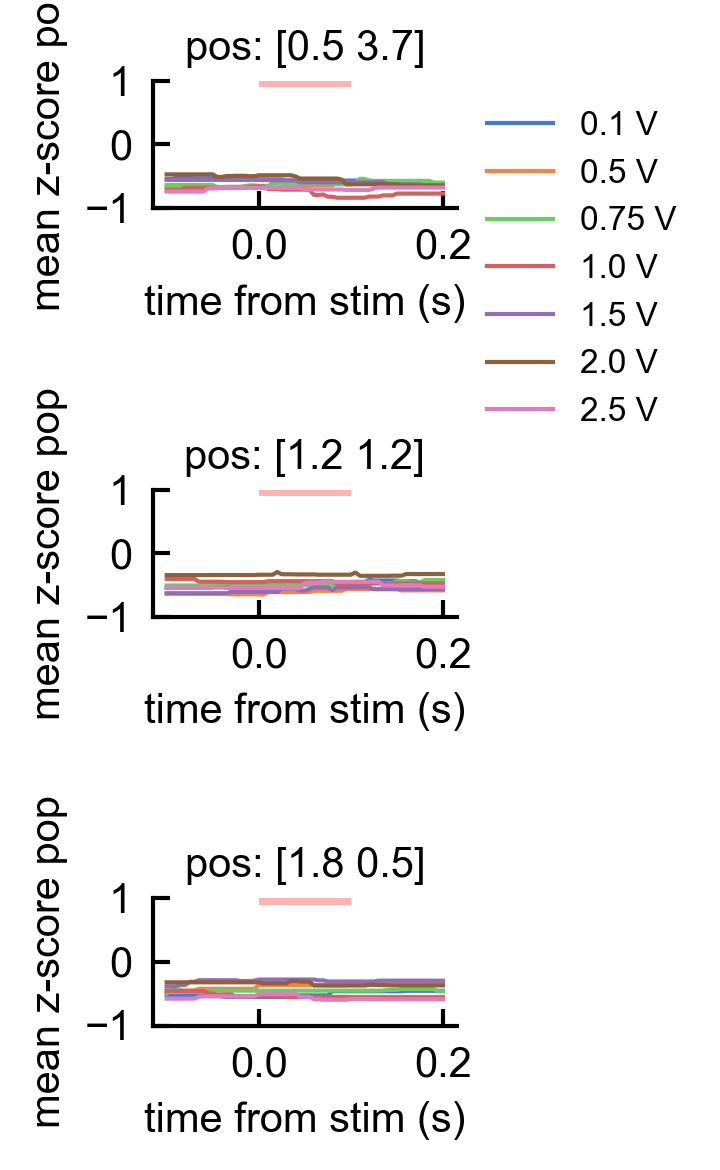

In [46]:
expPowers = getParams(ca_en=1, en=2)
powers = np.unique(expPowers.laserAmp)
positions = np.unique(np.vstack((expPowers.galvoX, expPowers.galvoY)), axis=1).T
window = np.arange(-0.1, 0.2, 0.005) # trial bins
f = plt.figure(figsize=(2.5, 4), dpi=300)
gs = mpl.gridspec.GridSpec(3, 1)
pos_labels = ['left V1', 'left SS', 'left ACA']
pop_mean = scipy.stats.zscore(np.mean(spk_mat[800:900,:], axis=0))

for iP, pos in enumerate(positions):
    pos_x, pos_y = pos
    match_x = np.squeeze(np.argwhere(expPowers.galvoX == pos_x))
    match_y = np.squeeze(np.argwhere(expPowers.galvoY == pos_y))
    match = np.intersect1d(match_x, match_y)

    ax = plt.subplot(gs[iP])
    plt.title(f'pos: {pos}')
    plt.axvspan(0, 0.1, ymin=0.95, ymax=1, color='red', lw=0, alpha=0.3)
    plt.xlabel('time from stim (s)')
    plt.ylabel('mean z-score pop')
    plt.ylim(-1, 1)

    for pow in powers:
        match_pow = np.squeeze(np.argwhere(expPowers.laserAmp == pow))
        match_both = np.intersect1d(match, match_pow)
        these_times = expPowers.laserOn[match_both]
        tr_times = [window+i for i in these_times]

        t_to_spks = scipy.interpolate.interp1d(bins[:-1], pop_mean, kind='previous')
        tr_spks = t_to_spks(tr_times)
        plt.plot(window, np.mean(tr_spks, axis=0), label=f'{pow} V')

    if iP == 0:
        plt.legend(bbox_to_anchor=(1,1))

In [37]:
spk_mat.shape

(939, 5258)

In [31]:
tr_spks.shape

(30, 61)

In [16]:
positions

array([[0.5, 3.7],
       [1.2, 1.2],
       [1.8, 0.5]])

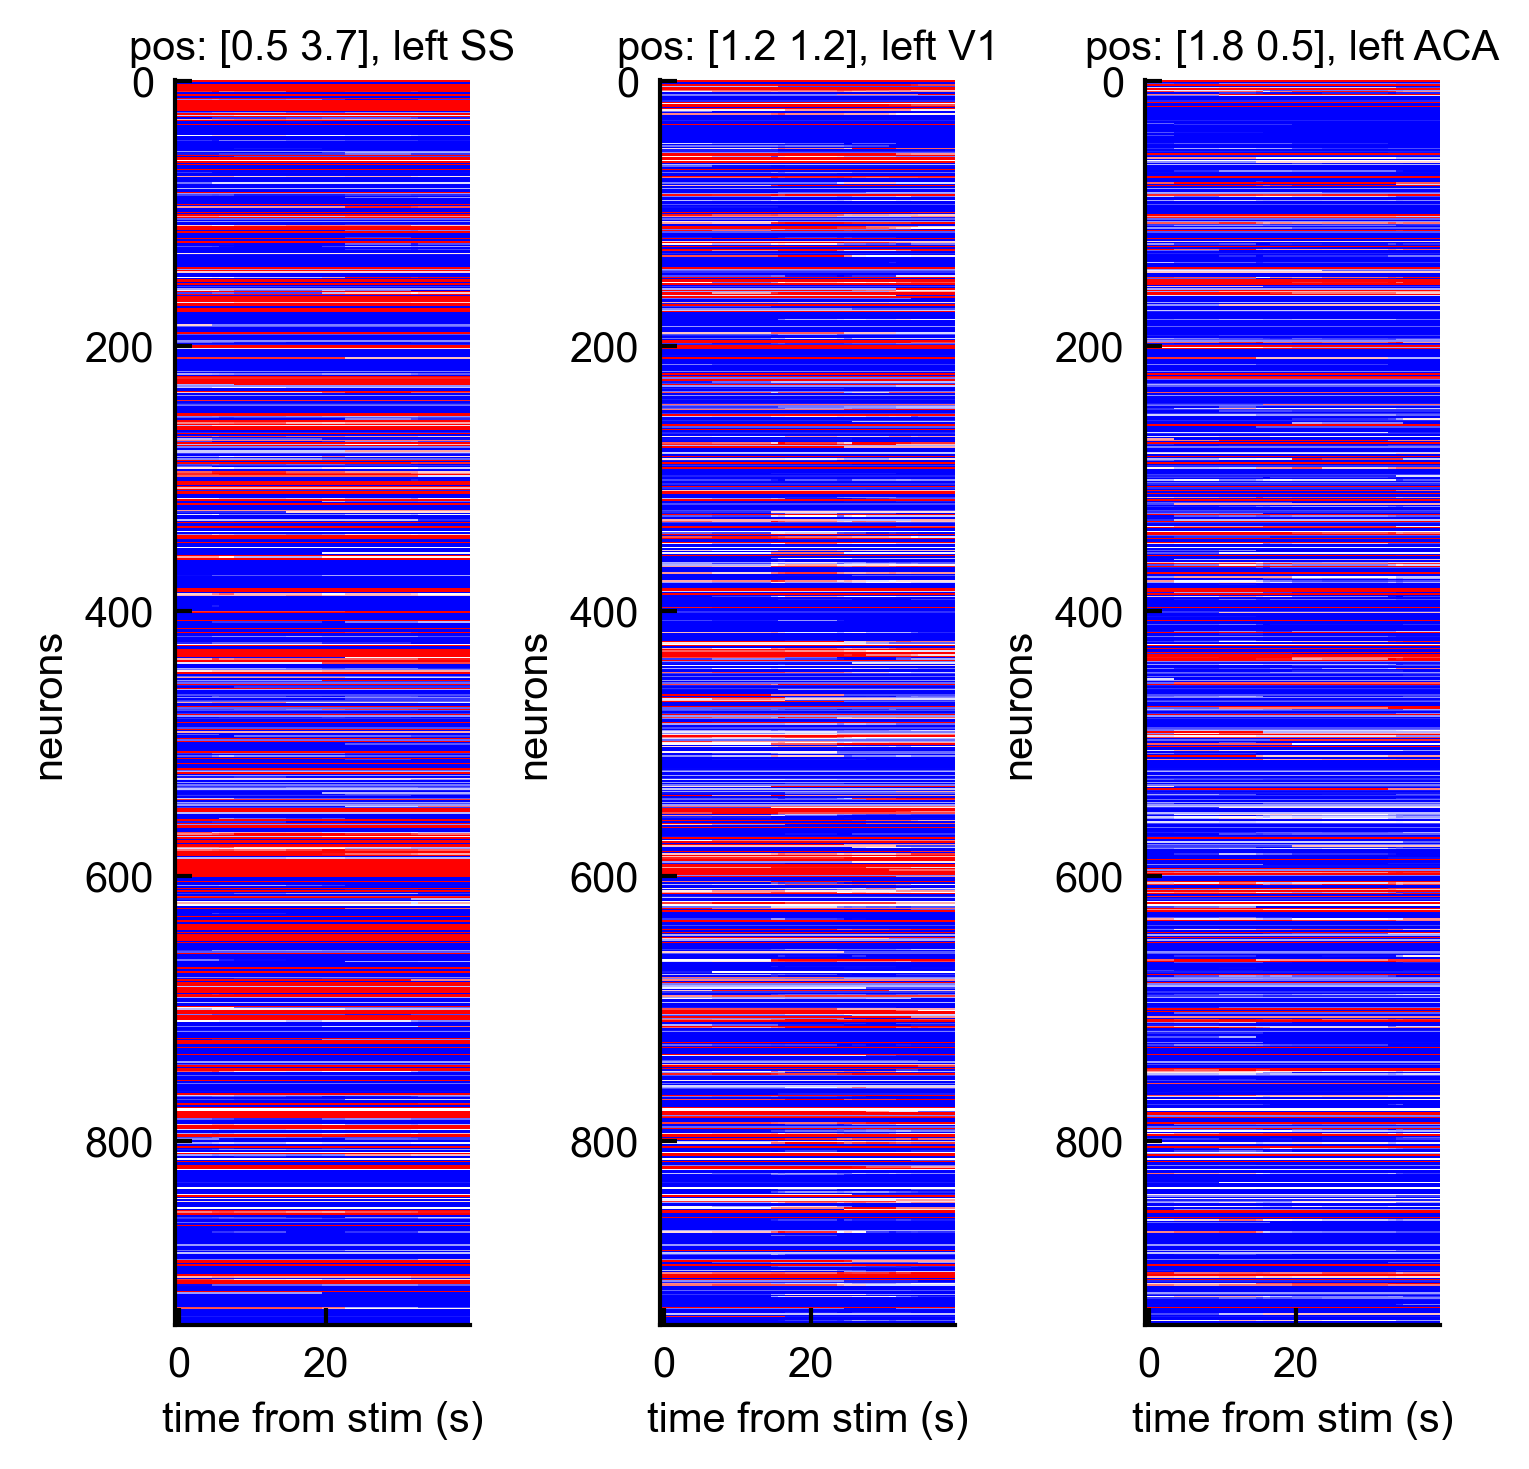

In [10]:
expPowers = getParams(1, 2)
powers = np.unique(expPowers.laserAmp)
positions = np.unique(np.vstack((expPowers.galvoX, expPowers.galvoY)), axis=1).T
window = np.arange(-0.1, 0.3, 0.01) # trial bins
f = plt.figure(figsize=(5, 5), dpi=300)
gs = mpl.gridspec.GridSpec(1, 3)
pos_labels = ['left SS', 'left V1', 'left ACA']

for iP, pos in enumerate(positions):
    pos_x, pos_y = pos
    match_x = np.squeeze(np.argwhere(expPowers.galvoX == pos_x))
    match_y = np.squeeze(np.argwhere(expPowers.galvoY == pos_y))
    match = np.intersect1d(match_x, match_y)

    ax = plt.subplot(gs[iP])
    plt.title(f'pos: {pos}, {pos_labels[iP]}')
    plt.axvspan(0, 0.1, ymin=0.95, ymax=1, color='red', lw=0, alpha=0.3)
    plt.xlabel('time from stim (s)')
    plt.ylabel('neurons')

    pow = powers[-1]
    match_pow = np.squeeze(np.argwhere(expPowers.laserAmp == pow))
    match_both = np.intersect1d(match, match_pow)
    these_times = expPowers.laserOn[match_both]
    tr_times = [window+i for i in these_times]

    t_to_spks = scipy.interpolate.interp1d(bins[:-1], spk_mat_z, axis=1, kind='previous')
    tr_spks = t_to_spks(tr_times)
    plot_spks = np.mean(tr_spks, axis=1)
    plt.imshow(plot_spks, clim=[-0.2, 0.2], cmap='bwr', aspect='auto')